In [1]:
import pandas as pd
from db_config import *
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import json
from shutil import copyfile
import os

import matplotlib
font = {'size'   : 21}
matplotlib.rc('font', **font)

In [2]:
print(datetime.now(),'Began run')

query_outcomes = "SELECT parts.part_id,parts.status,wells.seq_outcome,wells.plate_type,builds.build_name,wells.misplaced FROM parts \
        INNER JOIN wells ON parts.id = wells.part_id\
        INNER JOIN plates ON wells.plate_id = plates.id\
        INNER JOIN builds ON plates.build_id = builds.id"

query_frag = "SELECT parts.part_id,fragments.fragment_name,twist_orders.sub_name FROM parts\
        INNER JOIN part_frag ON parts.id = part_frag.part_id\
        INNER JOIN fragments ON part_frag.fragment_id = fragments.id\
        INNER JOIN frag_order ON fragments.id = frag_order.frag_id\
        INNER JOIN twist_orders ON twist_orders.id = frag_order.twist_order_id"

query_parts = "SELECT * FROM parts"

df_frag = pd.read_sql_query(query_frag, con=engine)
frags = df_frag.groupby('part_id')['fragment_name'].agg(len)
frags.name = 'Count'
frags = pd.DataFrame(frags).reset_index()
frags_dict = dict(zip(frags.part_id.tolist(),frags.Count.tolist()))
subs_dict = dict(zip(df_frag.part_id.tolist(),df_frag.sub_name.tolist()))
print(datetime.now(),'Finished frags')

def multiple(x):
    if len(x) == 1:
        x.append('N/A')
    return x

def find_outcome(x):
    if x in df_out_dict.keys():
        return df_out_dict[x]
    else:
        return ['N/A','N/A']
    
def find_build(x):
    if x in df_build_dict.keys():
        return df_build_dict[x]
    else:
        return ['N/A','N/A']
    
def simplify_outcome(x):
    if "mutation" in x:
        return 'cloning_mutation'
    elif "bad" in x:
        return 'sequence_failure'
#     elif x == 'cloning_error':
#         return 'cloning_failure'
    else:
        return x

df_res = pd.read_sql_query(query_outcomes, con=engine)
df_res = df_res[df_res.plate_type == 'seq_plate']

df_out = df_res.groupby('part_id')['seq_outcome'].apply(list)
df_out.name = 'Outcomes'
df_out = pd.DataFrame(df_out).reset_index()
df_out.Outcomes = df_out.Outcomes.apply(multiple)
df_out_dict = dict(zip(df_out.part_id.tolist(),df_out.Outcomes.tolist()))

df_build = df_res.groupby('part_id')['build_name'].apply(list)
df_build.name = 'Builds'
df_build = pd.DataFrame(df_build).reset_index()
df_build.Builds = df_build.Builds.apply(multiple)
df_build_dict = dict(zip(df_build.part_id.tolist(),df_build.Builds.tolist()))
print(datetime.now(),'Finished outcomes')

df_parts = pd.read_sql_query(query_parts, con=engine)
print('finished part query')
df_parts['Fragments'] = df_parts.part_id.apply(lambda x: frags_dict[x])
df_parts['Submission'] = df_parts.part_id.apply(lambda x: subs_dict[x])
df_parts['Order_number'] = df_parts.Submission.apply(lambda name: int(name[-3:]))
df_parts['Outcomes'] = df_parts.part_id.apply(find_outcome)
df_parts['Builds'] = df_parts.part_id.apply(find_build)
print('finished outcome and builds')
df_parts['Attempt_1_Outcome'] = df_parts.Outcomes.apply(lambda x: x[0])
df_parts['Attempt_1_Outcome_G'] = df_parts.Attempt_1_Outcome.apply(simplify_outcome)
df_parts['Attempt_1_Build'] = df_parts.Builds.apply(lambda x: x[0])
df_parts['Attempt_2_Outcome'] = df_parts.Outcomes.apply(lambda x: x[1])
df_parts['Attempt_2_Outcome_G'] = df_parts.Attempt_2_Outcome.apply(simplify_outcome)
df_parts['Attempt_2_Build'] = df_parts.Builds.apply(lambda x: x[1])
df_parts['Length'] = df_parts.seq.apply(len)
print(datetime.now(),'Finished building dataframe')
df_parts

2018-05-06 14:24:48.784832 Began run
2018-05-06 14:24:50.184317 Finished frags
2018-05-06 14:24:50.842700 Finished outcomes
finished part query
finished outcome and builds
2018-05-06 14:24:56.871168 Finished building dataframe


,id,part_id,part_name,part_type,organism,seq,status,cloning_enzyme,Fragments,Submission,Order_number,Outcomes,Builds,Attempt_1_Outcome,Attempt_1_Outcome_G,Attempt_1_Build,Attempt_2_Outcome,Attempt_2_Outcome_G,Attempt_2_Build,Length
0,749,BBF10K_000750,dnaN,cds,None,ATGAAGTTTACGATTCAGAAGGACCGCCTGGTTGAAAGCGTCCAGG...,ordered,BbsI,1,submission009,9,"[N/A, N/A]","[N/A, N/A]",N/A,N/A,N/A,N/A,N/A,N/A,1137
1,750,BBF10K_000751,gyrB,cds,None,ATGGAACAACAGCAGAATAGCTACGACGAAAATCAAATTCAAGTCC...,ordered,BbsI,2,submission009,9,"[N/A, N/A]","[N/A, N/A]",N/A,N/A,N/A,N/A,N/A,N/A,1917
2,751,BBF10K_000752,gyrA,cds,None,ATGAGCGAGCAGAACACCCCTCAGGTTCGTGAGATTAACATCAGCC...,ordered,BbsI,2,submission009,9,"[N/A, N/A]","[N/A, N/A]",N/A,N/A,N/A,N/A,N/A,N/A,2466
3,752,BBF10K_000753,guaB,cds,None,ATGTGGGAGAGCAAGTTTTCGAAAGAAGGCCTGACCTTTGATGATG...,ordered,BbsI,1,submission009,9,"[N/A, N/A]","[N/A, N/A]",N/A,N/A,N/A,N/A,N/A,N/A,1467
4,1918,BBF10K_001921,MG_RS00045,cds,None,ATGGAGTACTTCGATGCGCATTGCCACCTCAACTGTGAACCGCTGT...,ordered,BbsI,1,submission010,10,"[N/A, N/A]","[N/A, N/A]",N/A,N/A,N/A,N/A,N/A,N/A,789
5,2,BBF10K_000002,MMSYN1_0002,cds,None,ATGAACTTCTCTATTAATCGTATGGTTTTGTTAGATAATCTGTCGA...,sequence_confirmed,BbsI,1,submission001,1,"[sequence_confirmed, N/A]","[build000, N/A]",sequence_confirmed,sequence_confirmed,build000,N/A,N/A,N/A,1128
6,753,BBF10K_000754,serS,cds,None,ATGCTGGACACCAAGATGCTGCGCGCGAACTTTCAGGAGATTAAAG...,ordered,BbsI,1,submission009,9,"[N/A, N/A]","[N/A, N/A]",N/A,N/A,N/A,N/A,N/A,N/A,1278
7,754,BBF10K_000755,dnaX,cds,None,ATGTCCTACCAGGCGCTGTACCGCGTTTTCCGCCCGCAGAGATTCG...,ordered,BbsI,2,submission009,9,"[N/A, N/A]","[N/A, N/A]",N/A,N/A,N/A,N/A,N/A,N/A,1692
8,755,BBF10K_000756,holB,cds,None,ATGGCTATCAGCTGGAAGGAAATGAACGAGTTGCAACCGAGAGTGA...,ordered,BbsI,1,submission009,9,"[N/A, N/A]","[N/A, N/A]",N/A,N/A,N/A,N/A,N/A,N/A,990
9,756,BBF10K_000757,metS,cds,None,ATGCCGCAAGAGAATAATACCTTCTATATTACCACCCCGATTTACT...,ordered,BbsI,2,submission009,9,"[N/A, N/A]","[N/A, N/A]",N/A,N/A,N/A,N/A,N/A,N/A,1995


/Users/conarymeyer/anaconda3/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


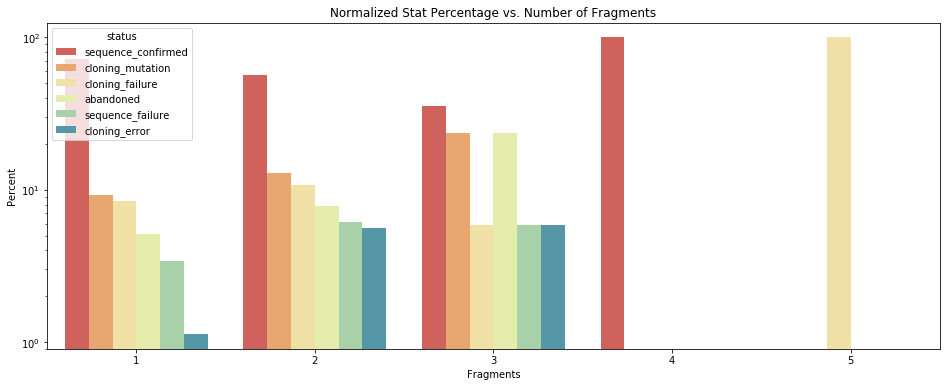

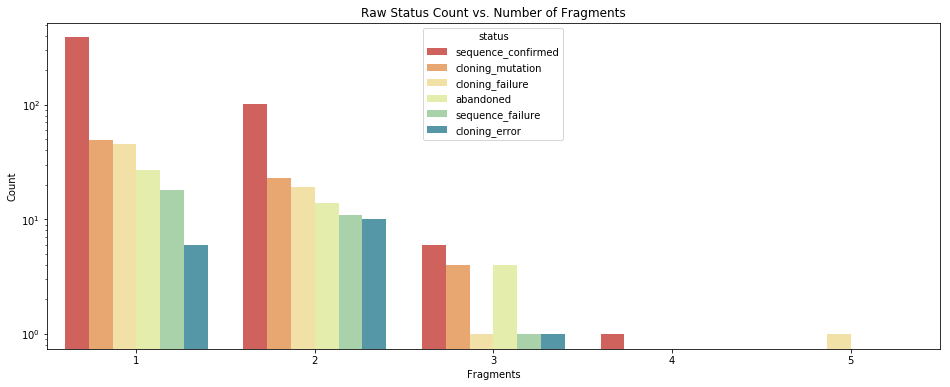

2018-05-06 14:24:58.729516 Finished outcome vs. fragments



,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
abandoned,45.0,1.488889,0.661342,1.0,1.0,1.0,2.0,3.0
cloning_error,17.0,1.705882,0.587868,1.0,1.0,2.0,2.0,3.0
cloning_failure,66.0,1.378788,0.674027,1.0,1.0,1.0,2.0,5.0
cloning_mutation,76.0,1.407895,0.592793,1.0,1.0,1.0,2.0,3.0
sequence_confirmed,494.0,1.234818,0.465354,1.0,1.0,1.0,1.0,4.0
sequence_failure,30.0,1.433333,0.568321,1.0,1.0,1.0,2.0,3.0


In [3]:
## BBREAKDOWN OF OUTCOMES BY NUMBER OF FRAGMENTS

data_b = df_parts[df_parts.cloning_enzyme == 'BbsI']

# data_fail = data_b[data_b.status != 'sequence_confirmed']
data_att = data_b[data_b.status != 'ordered']

frag_norm = (data_att.groupby('Fragments')['status'].value_counts() / data_att.groupby('Fragments')['status'].agg(len))
frag_norm.name = 'Percent'
norm_frag_df = pd.DataFrame(frag_norm).reset_index()
norm_frag_df.Percent = norm_frag_df.Percent * 100

dims = (16, 6)

fig1, ax1 = plt.subplots(figsize=dims)
g = sns.barplot(ax=ax1,data=norm_frag_df, x='Fragments', y='Percent', hue='status',palette="Spectral")
g.set_yscale('log')
plt.title("Normalized Stat Percentage vs. Number of Fragments")
plt.show()

total_frag_raw = (data_att.groupby('Fragments')['status'].value_counts())
total_frag_raw.name = 'Count'
total_raw = pd.DataFrame(total_frag_raw).reset_index()

fig2, ax2 = plt.subplots(figsize=dims)
t = sns.barplot(ax=ax2,data=total_raw, x='Fragments', y='Count', hue='status',palette='Spectral')
t.set_yscale('log')
plt.title("Raw Status Count vs. Number of Fragments")
plt.show()

print(datetime.now(),'Finished outcome vs. fragments\n')

data_att.groupby(data_att.status).Fragments.describe()


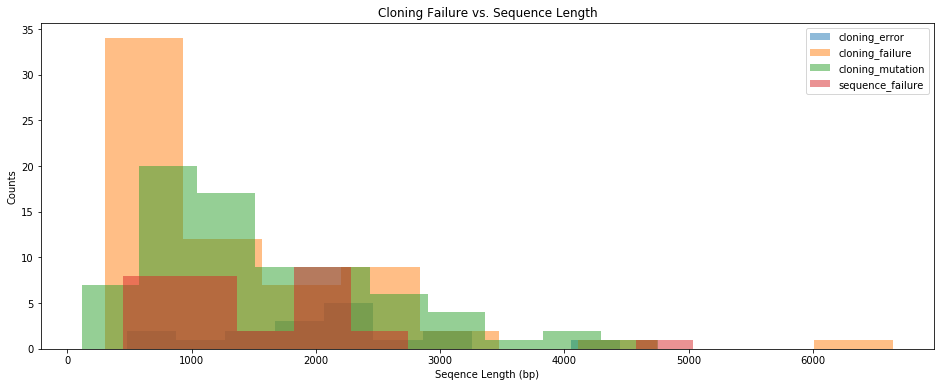

In [4]:
## CLONING FAILURE VERSUS LENGTH

data_fail = data_att[data_att.status != 'sequence_confirmed']
data_fail = data_fail[data_fail.status != 'abandoned']


fig3, ax3 = plt.subplots()

data_fail.groupby(data_fail.status).Length.plot.hist(ax=ax3,alpha=0.5,legend=True,figsize=(16,6),bins=10)
data_fail.groupby(data_fail.status).Length.describe()

plt.xlabel('Seqence Length (bp)')
plt.ylabel('Counts')
plt.title('Cloning Failure vs. Sequence Length')

fig3.savefig('../docs/Overall/raw_length.png')




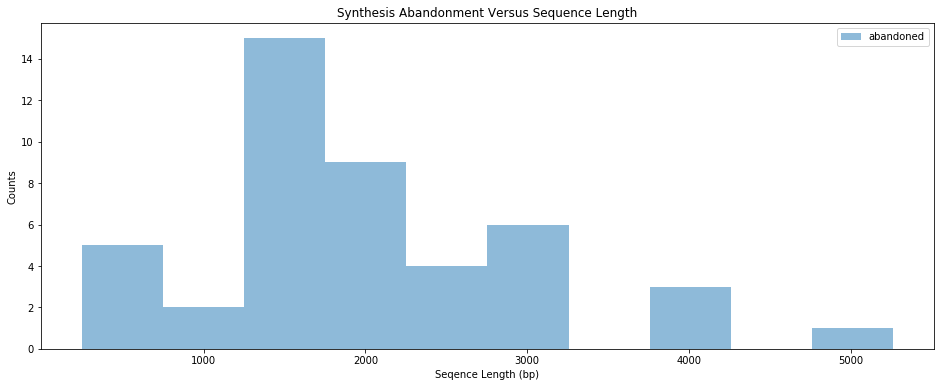

count      45.000000
mean     1996.733333
std      1031.001861
min       246.000000
25%      1410.000000
50%      1755.000000
75%      2499.000000
max      5262.000000
Name: Length, dtype: float64

In [5]:
## SYNTHESIS FAILURES PLOTTED AGAINST SEQUENCE LENGTH

data_order = data_b[data_b.status == 'abandoned']
fig4, ax4 = plt.subplots()

ax4.set_xticks([1000,2000,3000,4000,5000])

data_order.groupby(data_order.status).Length.plot.hist(ax=ax4,alpha=0.5,legend=True,figsize=(16,6),bins=10)

plt.xlabel('Seqence Length (bp)')
plt.ylabel('Counts')
plt.title('Synthesis Abandonment Versus Sequence Length')
plt.show()
fig4.savefig('../docs/Overall/syn_fail.png')

data_order.Length.describe()


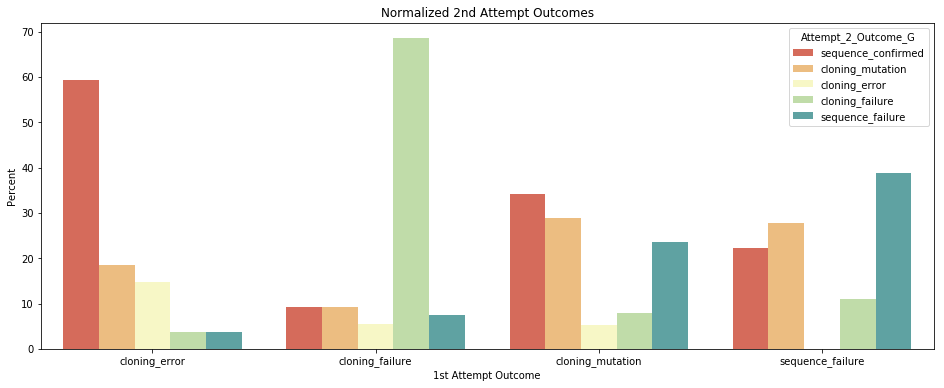

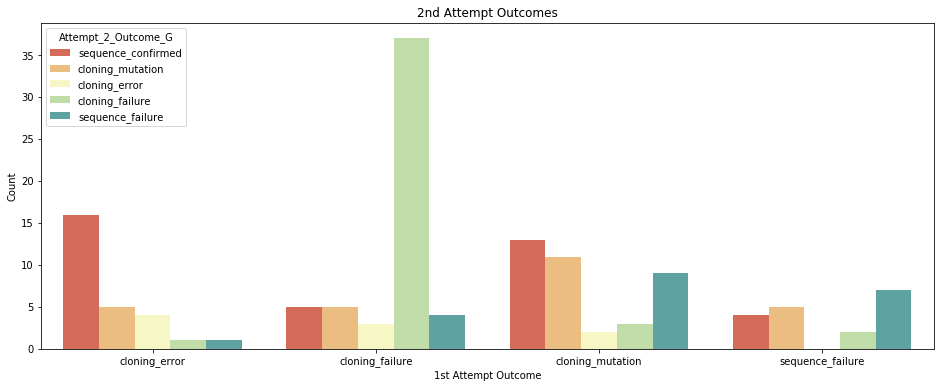

In [6]:
## SECOND ATTEMPT BREAKDOWN

# Elimination of irrelevant information for the plots
data_att = data_b[data_b.status != 'ordered']
data_att = data_att[data_att.status != 'received']
data_att = data_att[data_att.Attempt_1_Outcome_G != 'sequence_confirmed']
data_attempt = data_att[data_att.Attempt_2_Outcome_G != 'N/A']

# Normalizing the data by dividing the counts of each 2nd outcome by the total counts of each group of 1st outcomes
attempts_norm = (data_attempt.groupby('Attempt_1_Outcome_G')['Attempt_2_Outcome_G'].value_counts() / data_attempt.groupby('Attempt_1_Outcome_G')['Attempt_2_Outcome_G'].agg(len))
attempts_norm.name = 'Percent'
attempts_norm = pd.DataFrame(attempts_norm).reset_index()
attempts_norm.Percent = attempts_norm.Percent * 100

# Plot normalized data
dims = (16, 6)
fig1, ax = plt.subplots(figsize=dims)
p = sns.barplot(data=attempts_norm, x='Attempt_1_Outcome_G', y='Percent', hue='Attempt_2_Outcome_G',palette="Spectral").set_title("Normalized 2nd Attempt Outcomes")
plt.xlabel("1st Attempt Outcome")
plt.show()
fig1.savefig('../docs/Overall/norm_attempt.png')

# Caluclate the raw counts
attempts_raw = (data_attempt.groupby('Attempt_1_Outcome_G')['Attempt_2_Outcome_G'].value_counts())
attempts_raw.name = 'Count'
attempts_raw = pd.DataFrame(attempts_raw).reset_index()

# Plot the raw counts
fig2, ax = plt.subplots(figsize=dims)
g = sns.barplot(data=attempts_raw, x='Attempt_1_Outcome_G', y='Count', hue='Attempt_2_Outcome_G',palette="Spectral").set_title("2nd Attempt Outcomes")
plt.xlabel("1st Attempt Outcome")
plt.show()
fig2.savefig('../docs/Overall/raw_attempt.png')


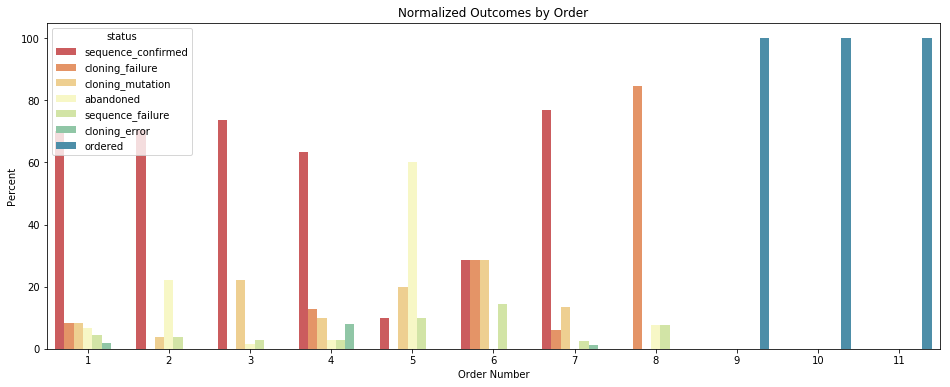

/Users/conarymeyer/anaconda3/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


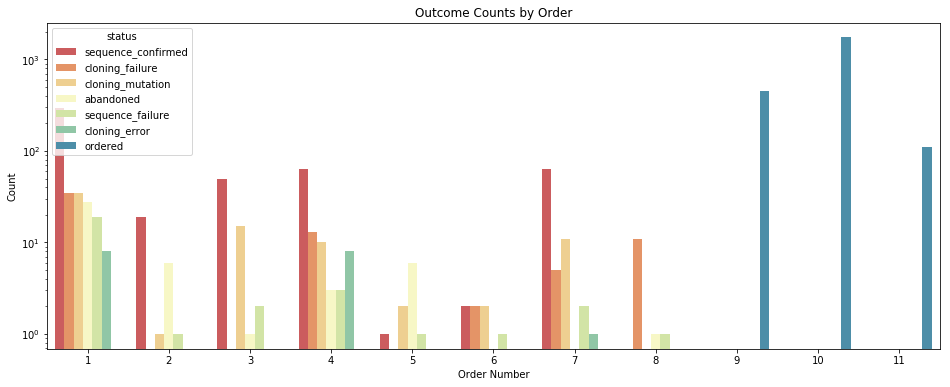

In [7]:
## BREAKING DOWN CLONING OUTCOMES BY ORDER NUMBER

# Normalizing the data by dividing the counts of each 2nd outcome by the total counts of each group of 1st outcomes
order_norm = (data_b.groupby('Order_number')['status'].value_counts() / data_b.groupby('Order_number')['status'].agg(len))
order_norm.name = 'Percent'
order_norm = pd.DataFrame(order_norm).reset_index()
order_norm.Percent = order_norm.Percent * 100

# Plot normalized data
dims = (16, 6)
fig1, ax = plt.subplots(figsize=dims)
p = sns.barplot(data=order_norm, x='Order_number', y='Percent', hue='status',palette="Spectral").set_title("Normalized Outcomes by Order")
plt.xlabel("Order Number")
plt.show()
fig1.savefig('../docs/Overall/norm_order.png')

# Caluclate the raw counts
order_raw = (data_b.groupby('Order_number')['status'].value_counts())
order_raw.name = 'Count'
order_raw = pd.DataFrame(order_raw).reset_index()

# Plot the raw counts
fig2, ax = plt.subplots(figsize=dims)
g = sns.barplot(data=order_raw, x='Order_number', y='Count', hue='status',palette="Spectral")

g.set_yscale('log')
plt.title("Outcome Counts by Order")
plt.xlabel("Order Number")
plt.show()
fig2.savefig('../docs/Overall/raw_order.png')

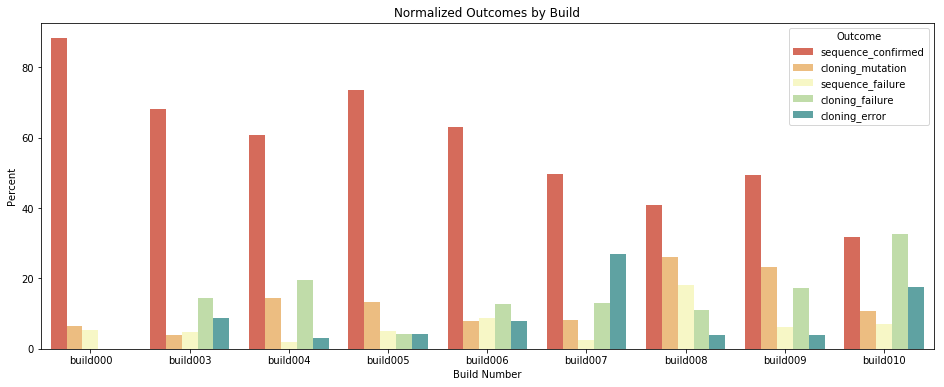

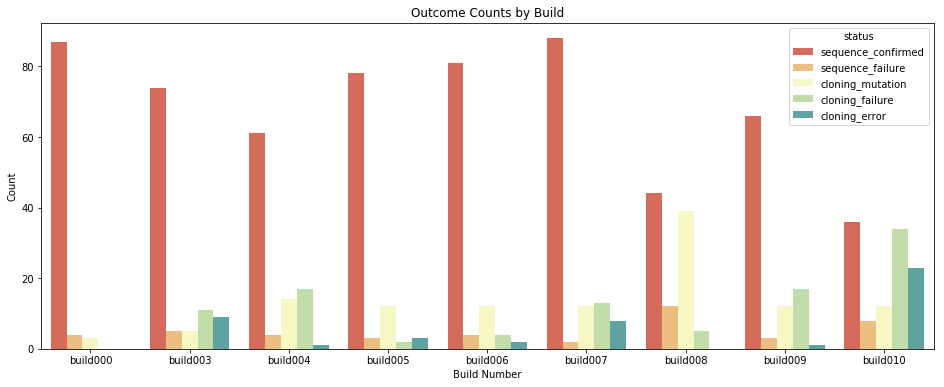

  build_name             Outcome    Percent
0   build000  sequence_confirmed  88.297872
1   build000    cloning_mutation   6.382979
2   build000    sequence_failure   5.319149 

  build_name             Outcome    Percent
3   build003  sequence_confirmed  68.269231
4   build003     cloning_failure  14.423077
5   build003       cloning_error   8.653846
6   build003    sequence_failure   4.807692
7   build003    cloning_mutation   3.846154 

   build_name             Outcome    Percent
8    build004  sequence_confirmed  60.824742
9    build004     cloning_failure  19.587629
10   build004    cloning_mutation  14.432990
11   build004       cloning_error   3.092784
12   build004    sequence_failure   2.061856 

   build_name             Outcome    Percent
13   build005  sequence_confirmed  73.469388
14   build005    cloning_mutation  13.265306
15   build005    sequence_failure   5.102041
16   build005       cloning_error   4.081633
17   build005     cloning_failure   4.081633 

   build_nam

In [8]:
## BUILD ATTEMPT BREAKDOWN

df_int = df_res
df_int['Outcome'] = df_int.seq_outcome.apply(simplify_outcome)

# Normalizing the data by dividing the counts of each 2nd outcome by the total counts of each group of 1st outcomes
build_norm = (df_int.groupby('build_name')['Outcome'].value_counts() / df_int.groupby('build_name')['Outcome'].agg(len))
build_norm.name = 'Percent'
build_norm = pd.DataFrame(build_norm).reset_index()
build_norm.Percent = build_norm.Percent * 100

# Plot normalized data
dims = (16, 6)
fig1, ax = plt.subplots(figsize=dims)
p = sns.barplot(data=build_norm, x='build_name', y='Percent', hue='Outcome',palette="Spectral").set_title("Normalized Outcomes by Build")
plt.xlabel("Build Number")
plt.show()
fig1.savefig('../docs/Overall/norm_build.png')

# Caluclate the raw counts
build_raw = (df_int.groupby('build_name')['status'].value_counts())
build_raw.name = 'Count'
build_raw = pd.DataFrame(build_raw).reset_index()

# Plot the raw counts
fig2, ax = plt.subplots(figsize=dims)
g = sns.barplot(data=build_raw, x='build_name', y='Count', hue='status',palette="Spectral")

# g.set_yscale('log')
plt.title("Outcome Counts by Build")
plt.xlabel("Build Number")
plt.show()
fig2.savefig('../docs/Overall/raw_build.png')


for i,build in build_norm.groupby('build_name'):
    print(build,'\n')

In [9]:
## GENERATE SANKEY DIAGRAMS

def add_branch(source,target,amount,nodes,links):
    if amount == 0:
        return nodes,links
    nodes += [source,target]
    links.append([source,target,amount])
    return nodes,links

def gen_sankey(nodes,links,sankey={'nodes':[],'links':[]}):
    node_dict = dict([[y,x] for x,y in enumerate(pd.Series(nodes).unique())])
    print(node_dict)
    for name in node_dict.keys():
        sankey['nodes'].append({'name' : name})
    for source,target,value in links:
        sankey['links'].append({
            "source":node_dict[source],
            "target":node_dict[target],
            "value":value
        })
    return sankey

desired_dfs = [df[1] for df in data_b.groupby('Order_number')]
df_names = ["Order_"+str(num+1).zfill(3) for num in range(len(data_b.groupby('Order_number')))]
print(df_names)

desired_dfs.append(data_b)
df_names.append('Overall')

for name,df in zip(df_names,desired_dfs):
    sankey = {}

    nodes = ['Total_ordered']
    links = []
    sankey['nodes'] = []
    sankey['links'] = []

    # Orders
    total = len(df)
    orders = pd.DataFrame(df.Order_number.value_counts())
    order_names = ['Order_'+str(order).zfill(3) for order in orders.index.tolist()]
    order_counts = [int(count) for count in orders.Order_number.tolist()]
    
    for order,count in zip(order_names,order_counts):
        nodes,links = add_branch(order,'Total_ordered',count,nodes,links)

    # Synthesizing
    syn = len(df[df.status == 'ordered'])
    nodes,links = add_branch('Total_ordered','Synthesizing',syn,nodes,links)

        
    # Abandoned
    abandoned = len(df[df.status == 'abandoned'])
    nodes,links = add_branch('Total_ordered','Abandoned',abandoned,nodes,links)

    # Received
    received = total-abandoned-syn
    nodes,links = add_branch('Total_ordered','Received',received,nodes,links)

    # Attempted
    not_attempted = len(df[df.status == 'received'])
    nodes,links = add_branch('Received','Not_attempted',not_attempted,nodes,links)
    attempted = received-not_attempted
    nodes,links = add_branch('Received','Attempted',attempted,nodes,links)

    # Outcomes 
    data_att = df[df.status != 'ordered']
    data_att = data_att[data_att.status != 'abandoned']
    outcomes = pd.DataFrame(data_att.status.value_counts())
    out = outcomes.index.tolist()
    count = outcomes.status.tolist()
    for out,count in zip(out,count):
        print(out,count)
        nodes,links = add_branch('Attempted',out,count,nodes,links)

    sankey = gen_sankey(nodes,links,sankey=sankey)
    
    path = '{}/docs/{}'.format(BASE_PATH,name)
    if os.path.exists(path):
        print("Directory for {} already exists".format(name))
    else:
        # Generates a new directory with the ID# as its name
        os.makedirs(path)
        print("Making directory for {}".format(name))    

    with open("{}/sankey.json".format(path),"w+") as json_file:
        json.dump(sankey,json_file,indent=2)
        
    copyfile('../docs/sankey/sankey.html','{}/sankey.html'.format(path))
        
    date = str(datetime.now()).split(" ")[0]
    if name == 'Overall':
        with open('../docs/sankey/index.md','r') as md_file:
            data = md_file.read()
            print(data)
            data = data.replace('[DATE]',date)
            print(data)
        with open('{}/index.md'.format(path),'w') as md_file:
            md_file.write(data)
    else:
        with open('../docs/sankey/order.md','r') as md_file:
            data = md_file.read()
            print(data)
            data = data.replace('[ORDER]',name)
            data = data.replace('[DATE]',date)
            print(data)
        with open('{}/index.md'.format(path),'w') as md_file:
            md_file.write(data)

        
    print("Check sankey")
#     input()

['Order_001', 'Order_002', 'Order_003', 'Order_004', 'Order_005', 'Order_006', 'Order_007', 'Order_008', 'Order_009', 'Order_010', 'Order_011']
sequence_confirmed 295
cloning_failure 35
cloning_mutation 35
sequence_failure 19
cloning_error 8
{'Total_ordered': 0, 'Order_001': 1, 'Abandoned': 2, 'Received': 3, 'Attempted': 4, 'sequence_confirmed': 5, 'cloning_failure': 6, 'cloning_mutation': 7, 'sequence_failure': 8, 'cloning_error': 9}
Directory for Order_001 already exists
# Welcome to the Free Genes project

## [ORDER] status

<iframe width="800" height="500" src="sankey.html"></iframe>

### Above is a Sankey Diagram reflecting the current status of the Free Genes project workflow

##### Last updated: [DATE]

# Welcome to the Free Genes project

## Order_001 status

<iframe width="800" height="500" src="sankey.html"></iframe>

### Above is a Sankey Diagram reflecting the current status of the Free Genes project workflow

##### Last updated: 2018-05-06

Check sankey
sequence_confirmed 

# Welcome to the Free Genes project

## Current status

<iframe width="800" height="500" src="sankey.html"></iframe>

### Above is a Sankey Diagram reflecting the current status of the Free Genes project workflow

## General Stats

[General Table]

## Detailed Results

### Individual Cloning Run Breakdown

![Cloning Run Breakdown](./raw_build.png)
![](./norm_build.png)

### Individual Twist Order Breakdown

![Twist Order Breakdown](./raw_order.png)
![](./norm_order.png)

### Cloning Rework Breakdown

![Rework Breakdown](./raw_attempt.png)
![](./norm_attempt.png)

### Synthesis Failure Breakdown

![Synthesis Failure Breakdown](./syn_fail.png)

### Cloning Failure versus Sequence Length

![Cloning Failure versus Sequence Length](./raw_length.png)

### Table of genes that have failed twice to clone

[Failure Table]

##### Last updated: [DATE]

# Welcome to the Free Genes project

## Current status

<iframe width="800" height="500" src="sankey.html"></iframe>

### Above is a Sankey Diagram

In [10]:
# with open('../docs/sankey/index.md','r') as md_file:
#     data = md_file.read()
#     print(data)
#     data = data.replace('[INSERT LINK]','inserted')
#     print(data)
# with open('../docs/sankey/index.md','w') as md_file:
#     md_file.write(data)

In [11]:
# orders = ['submission009','submission010','submission011']
# aband = df_parts[df_parts.apply(lambda row: row.Submission not in orders, axis=1)]
# to_aband = aband[aband.status == 'ordered']
# print(len(to_aband))
# to_abandon = to_aband.part_id.tolist()

# for part in to_abandon:
#     current = session.query(Part).filter(Part.part_id == part).one()
#     current.status = 'abandoned'
    
# session.commit()

In [12]:
fail2 = df_parts[df_parts.Attempt_1_Outcome_G == 'cloning_failure']
fail2 = fail2[fail2.Attempt_2_Outcome_G == 'cloning_failure']
fail2_limit = fail2[['part_id','part_name','Length','Fragments','part_type']]
fail2_limit

string = '| Part ID | Gene Name | Sequence Length | # of Fragments | Part Type |\n'
string += '| ------------- | ------------- | :-------------: | :-------------: | ------------- |\n'
for i,row in fail2_limit.iterrows():
    string += '| {} | {} | {} | {} | {} |\n'.format(row.part_id,row.part_name,row.Length,row.Fragments,row.part_type)
    
total_ordered_bp = df_parts.Length.sum()
total_ordered_g = len(df_parts)

rec = ['ordered','abandoned']
total_received = df_parts[df_parts.apply(lambda row: row.status not in rec, axis=1)]
total_received_bp = total_received.Length.sum()
total_received_g = len(total_received)

total_built = df_parts[df_parts.status == 'sequence_confirmed']
total_built_bp = total_built.Length.sum()
total_built_g = len(total_built)

rework = ['build008','build010']
normal_builds = df_parts[df_parts.apply(lambda row: row.Attempt_1_Build not in rework, axis=1)]
total_attempted = normal_builds[normal_builds.Attempt_1_Outcome_G != 'N/A']
total_built_first = normal_builds[normal_builds.Attempt_1_Outcome_G == 'sequence_confirmed']
total_attempted_g = len(total_attempted)
total_built_first_g = len(total_built_first)
success_rate = round((total_built_first_g / total_attempted_g)*100)


overall = '| Amount Ordered | Amount Received  | Amount Built | Cloning Success Rate |\n'
overall += '| :-------------: | :-------------: | :-------------: | :-------------: |\n'
overall += '| {}bp / {}genes | {}bp / {}genes | {}bp / {}genes | {}% |'.format(total_ordered_bp,total_ordered_g,total_received_bp,total_received_g,total_built_bp,total_built_g,success_rate)
    
with open('../docs/Overall/index.md','r') as md_file:
    data = md_file.read()
    print(data)
    data = data.replace('[Failure Table]',string)
    data = data.replace('[General Table]',overall)
    print(data)
with open('../docs/Overall/index.md'.format(path),'w') as md_file:
    md_file.write(data)


# Welcome to the Free Genes project

## Current status

<iframe width="800" height="500" src="sankey.html"></iframe>

### Above is a Sankey Diagram reflecting the current status of the Free Genes project workflow

## General Stats

[General Table]

## Detailed Results

### Individual Cloning Run Breakdown

![Cloning Run Breakdown](./raw_build.png)
![](./norm_build.png)

### Individual Twist Order Breakdown

![Twist Order Breakdown](./raw_order.png)
![](./norm_order.png)

### Cloning Rework Breakdown

![Rework Breakdown](./raw_attempt.png)
![](./norm_attempt.png)

### Synthesis Failure Breakdown

![Synthesis Failure Breakdown](./syn_fail.png)

### Cloning Failure versus Sequence Length

![Cloning Failure versus Sequence Length](./raw_length.png)

### Table of genes that have failed twice to clone

[Failure Table]

##### Last updated: 2018-05-06

# Welcome to the Free Genes project

## Current status

<iframe width="800" height="500" src="sankey.html"></iframe>

### Above is a Sankey Dia

In [13]:
total_ordered_bp = df_parts.Length.sum()
total_ordered_g = len(df_parts)

rec = ['ordered','abandoned']
total_received = df_parts[df_parts.apply(lambda row: row.status not in rec, axis=1)]
total_received_bp = total_received.Length.sum()
total_received_g = len(total_received)

total_built = df_parts[df_parts.status == 'sequence_confirmed']
total_built_bp = total_built.Length.sum()
total_built_g = len(total_built)

rework = ['build008','build010']
normal_builds = df_parts[df_parts.apply(lambda row: row.Attempt_1_Build not in rework, axis=1)]
total_attempted = normal_builds[normal_builds.Attempt_1_Outcome_G != 'N/A']
total_built_first = normal_builds[normal_builds.Attempt_1_Outcome_G == 'sequence_confirmed']
total_attempted_g = len(total_attempted)
total_built_first_g = len(total_built_first)
success_rate = round((total_built_first_g / total_attempted_g)*100)


overall = '| Amount Ordered | Amount Received  | Amount Built | Cloning Success Rate |\n'
overall += '| :-------------: | :-------------: | :-------------: | :-------------: |\n'
overall += '| {} bp / {} genes | {} bp / {} genes | {} bp / {} genes | {}% |'.format(total_ordered_bp,total_ordered_g,total_received_bp,total_received_g,total_built_bp,total_built_g,success_rate)

print(success_rate)
print(overall)

71
| Amount Ordered | Amount Received  | Amount Built | Cloning Success Rate |
| :-------------: | :-------------: | :-------------: | :-------------: |
| 3615654 bp / 3229 genes | 915639 bp / 702 genes | 609369 bp / 495 genes | 71% |
